# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Даны исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

В работе важны:

- качество предсказания;
- скорость предсказания;
- время обучения;
- значение метрики RMSE должно быть меньше 2500.

## Библиотеки и информация о данных

In [4]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import os
import timeit
import re
from datetime import datetime
from phik import phik_matrix
from phik.report import plot_correlation_matrix


# Подготовка данных
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder

# Для пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Модели и метрика
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [5]:
# константы
RANDOM_STATE = 1
TEST_SIZE = 0.2

In [6]:
df  = os.path.abspath('autos.csv')   # выгрузка датасета. Файл должен быть в той же директории, где находится тетрадка
with open(df) as file:
    data = pd.read_csv(file, 
                       parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], 
                       date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date()) # исключим время (такая точность не нужна в данной работе)

In [7]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07
1,2016-03-24,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06


In [8]:
def about_df(list_df):
    '''выводит информацию о всех датасетах из списка list_df'''
    for c, i in enumerate(list_df):
        print("**** DATASET_"+str(c+1)+' ****')
        display(i.info())
        display(i.describe().round(2))
        print(f'Количество дубликатов: {i.duplicated().sum()}')
        print('Количество пропущенных значений:', i.isnull().sum(), sep='\n')
        print()

In [9]:
about_df([data])

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   35436

None

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.00,354369.00,354369.00,354369.00,354369.00,354369,354369.0,354369.00,354369
mean,2016-03-20 21:16:58.440100608,4416.66,2004.23,110.09,128211.17,5.71,2016-03-20 19:12:07.753274112,0.0,50508.69,2016-03-29 11:28:24.714577408
min,2016-03-05 00:00:00,0.00,1000.00,0.00,5000.00,0.00,2014-03-10 00:00:00,0.0,1067.00,2016-03-05 00:00:00
25%,2016-03-13 00:00:00,1050.00,1999.00,69.00,125000.00,3.00,2016-03-13 00:00:00,0.0,30165.00,2016-03-23 00:00:00
50%,2016-03-21 00:00:00,2700.00,2003.00,105.00,150000.00,6.00,2016-03-21 00:00:00,0.0,49413.00,2016-04-03 00:00:00
75%,2016-03-29 00:00:00,6400.00,2008.00,143.00,150000.00,9.00,2016-03-29 00:00:00,0.0,71083.00,2016-04-06 00:00:00
max,2016-04-07 00:00:00,20000.00,9999.00,20000.00,150000.00,12.00,2016-04-07 00:00:00,0.0,99998.00,2016-04-07 00:00:00
std,NaN,4514.16,90.23,189.85,37905.34,3.73,NaN,0.0,25783.10,NaN


Количество дубликатов: 6828
Количество пропущенных значений:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64



**Вывод**
<br> Представленный датасет состоит из 16 колонок (7шт. типа int64 и 9 шт. типа object) и 354369 строк, занимает много памяти (43,3+ mb). Кроме этого имеет 6828 дубликатов, пропущенные значения в колонках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`, неестественные значения в колонках `Price`, `RegistrationYear`, `Power`, `RegistrationMonth`, даты в формате object. Колонка `NumberOfPictures` содержит одни нули, поэтому ее необходимо удалить в следующем разделе, т.к. она бесполезна для модели. Обработаем аномалии, пропуски, названия колонок, дубликаты, колонки с датами, а также сократим занимаемый объем в следущем разделе. 

## Предобработка данных

Вначале приведем названия колонок к более правильному и удобному виду:

In [13]:
data.head(1)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07


In [14]:
data = data.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())

Удалим колонку `number_of_pictures` т.к. она содержит одни нули, поэтому бесполезна для моделирования:

In [16]:
data = data.drop('number_of_pictures', axis=1)

Определим, есть ли в датасете анкеты, которые были скачаны из БД не в 2016 год:

In [18]:
data.query('date_crawled  < "2016-01-01" | date_crawled  > "2016-12-31"')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen


Все анкеты были скачены в 2016 году. Удалим колонки `date_crawled`, `date_created` и `last_seen` т.к. они лишь указывают на дату скачивания анкеты из БД, дату создания этой анкеты и на активность пользователя и никак не определяют стоимость автомобиля:

In [20]:
data = data.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)

Поскольку пробег у всех авто больше 1 тыс. км, то для удобства переведем колонку kilometer в тыс. км:

In [22]:
data= data.rename(columns={'registration_year': 'reg_year',    # переименуем колонки (для удобства)
                           'kilometer': 'thousand_km', 
                           'registration_month': 'reg_month'})

data['thousand_km'] = (data['thousand_km']/1000).astype(int)
data.thousand_km.min()   # для проверки

5

Устраним дубликаты:

In [24]:
print('Количество дублей в датасете, %:', data.duplicated().sum() * 100 / len(data))

Количество дублей в датасете, %: 6.0199961057541715


In [25]:
data = data.drop_duplicates().reset_index(drop=True)

Проверим наличие неявных дублей в категориальных колонках:

In [27]:
[data[i].unique() for i in ['vehicle_type', 'gearbox', 'model', 
                            'fuel_type', 'brand', 'repaired']]

[array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
        'wagon', 'other'], dtype=object),
 array(['manual', 'auto', nan], dtype=object),
 array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
        '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
        'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
        'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
        'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
        'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
        'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
        'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
        '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
        'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
        'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
        'vectra', 'berlingo', '

In [28]:
print('Количество данных с petrol, %:', len(data.query('fuel_type == "petrol"')) * 100 / len(data))
print('Количество данных с gasoline, %:', len(data.query('fuel_type == "gasoline"')) * 100 / len(data))

Количество данных с petrol, %: 61.01202272427005
Количество данных с gasoline, %: 27.60662510959776


petrol и gasoline это одно и тоже (бензин). Различие между этими терминами скорее языковое: в Великобритании и многих других странах преобладает термин «petrol», а в США чаще используется термин «gasoline». Т.е. этот термин может указывать на страну расположения автомобиля. поэтому оставим оба наименования бензина.

Также важно заметить, что rover как отдельной компании не существует, есть только land rover. Проверим одинаковые ли модели авто указаны под этими двумя брендами:

In [31]:
data.query('brand == "rover"').model.unique(), data.query('brand == "land_rover"').model.unique()

(array(['other', 'discovery', nan, 'rangerover', 'freelander', 'defender'],
       dtype=object),
 array(['discovery', 'freelander', 'defender', nan, 'range_rover',
        'serie_2', 'range_rover_sport', 'other', 'range_rover_evoque',
        'serie_3', 'serie_1'], dtype=object))

Похоже, что rover - часть land_rover. Исходя из этого заменим rover на land_rover и модель rangerover на range_rover:

In [33]:
data['brand'] = data['brand'].replace('rover', 'land_rover')
data['model'] = data['model'].replace('rangerover', 'range_rover')

На всякий случай проверим, есть ли у прочих брендов одинаковые названия моделей:

In [35]:
print(f'Количество комбинаций модель + марка: {len(data.groupby(['model', 'brand']).count())}. Количество моделей: {data.model.nunique()}')

Количество комбинаций модель + марка: 292. Количество моделей: 249


Комбинаций "модель + марка" больше, чем просто моделей. Это означает, что у одной модели указано несколько марок. Посмотрим, что это за автомобили

In [37]:
temp = data.groupby(['model', 'brand'])[['postal_code']].count().reset_index()   # датафрейм с моделями, марками и их количеством  
dubl = temp[temp.duplicated('model', keep=False)]
dubl

,model,brand,postal_code
5,1_reihe,mazda,92
6,1_reihe,peugeot,1129
11,3_reihe,mazda,1250
12,3_reihe,peugeot,2012
16,5_reihe,mazda,312
17,5_reihe,peugeot,109
120,grand,chrysler,109
121,grand,jeep,230
122,grand,suzuki,194
153,matiz,chevrolet,267


In [38]:
data.query('model == "1_reihe"')['brand'].value_counts()

brand
peugeot    1129
mazda        92
Name: count, dtype: int64

Восстановим верные названия марок у моделей авто: 1_reihe, 3_reihe, 5_reihe - это не mazda или peugeot, возможно это порядковый номер марки на немецком поэтому заменим на 1_reihe_mazda, 3_reihe_mazda, 5_reihe_mazda и 1_reihe_peugeot, 3_reihe_peugeot, 5_reihe_peugeot соответственно.
<br>У chrysler есть grand caravan и grand voyager. У jeep - grand cherokee. У suzuki - grand vitara. Таким образом заменим grand для jeep и suzuki на полные названия, а у chrysler оставим grand.
<br>У chevrolet и daewoo есть марки matiz и это разные машины, поэтому заменим марки на matiz_chev и matiz_daew.
<br>other заменить не сможем.

In [40]:
cols = ['1_reihe', '3_reihe', '5_reihe']
for i in cols:
    data.loc[(data['brand'] == 'mazda') & (data['model'] == i), 'model'] = i+'_mazda'
    data.loc[(data['brand'] == 'peugeot') & (data['model'] == i), 'model'] = i+'_peugeot'

data.loc[(data['brand'] == 'jeep') & (data['model'] == 'grand'), 'model'] = 'grand_cherokee'
data.loc[(data['brand'] == 'suzuki') & (data['model'] == 'grand'), 'model'] = 'grand_vitara'
data.loc[(data['brand'] == 'chevrolet') & (data['model'] == 'matiz'), 'model'] = 'matiz_chevrolet'
data.loc[(data['brand'] == 'daewoo') & (data['model'] == 'matiz'), 'model'] = 'matiz_daewoo'

In [41]:
temp = data.groupby(['model', 'brand'])['postal_code'].count().reset_index()   # проверка
dubl = temp[temp.duplicated('model', keep=False)]
dubl

,model,brand,postal_code
172,other,alfa_romeo,497
173,other,audi,998
174,other,bmw,210
175,other,chevrolet,907
176,other,chrysler,369
177,other,citroen,1770
178,other,dacia,22
179,other,daewoo,87
180,other,daihatsu,108
181,other,fiat,1706


Посмотрим на колонку `postal_code`:

In [43]:
data.postal_code.nunique()

8143

Видно, что в почтовом коде много уникальных значений. Это ухудшит обобщающую способность модели, поэтому следует уменьшить их количество. Например можно оставить только первые 3 цифры, которые могут характеризовать регион продажи автомобиля.

In [45]:
data.head(2)

,price,vehicle_type,reg_year,gearbox,power,model,thousand_km,reg_month,fuel_type,brand,repaired,postal_code
0,480,NaN,1993,manual,0,golf,150,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125,5,gasoline,audi,yes,66954


In [46]:
data['postal_code'] = data['postal_code'].apply(lambda x: int(str(x)[:3]))
data.head(2)

,price,vehicle_type,reg_year,gearbox,power,model,thousand_km,reg_month,fuel_type,brand,repaired,postal_code
0,480,NaN,1993,manual,0,golf,150,0,petrol,volkswagen,NaN,704
1,18300,coupe,2011,manual,190,NaN,125,5,gasoline,audi,yes,669


In [47]:
memory_before = data.memory_usage().sum() / 1024**2
print('Объем датасета, мб:', memory_before)

Объем датасета, мб: 30.490482330322266


Видно, что датасет занимает много памяти (30.49 MB). Преобразуем некоторые типы данных из int64 для сокращения занимаемого объема.
<br>Например у int8 диапазон значений: от -128 до 127. У int16: от -32768 до 32767. У int32: от -2147483648 до 2147483647. На основе известных минимумов и максимумов переведем колонки с типом int в соответствующий формат. Для этого напишем функцию int_to_int().

In [49]:
def int64_to_int(df):
    
    '''Определяет колонки в датафрейме df с типом int64 
    и переводит их в менее объемный тип: int8, int16, int32'''
    
    int_cols = list(df.select_dtypes(np.int64).columns)     # список с колонками типа int64

    for i in int_cols:                                      # в цикле меняем тип в зависимости от максимального и 
        min_col = df[i].min()                               # и минимального значений
        max_col = df[i].max()
        if min_col > -128 and max_col < 127:    
            df[i] = df[i].astype('int8')
            continue
        elif min_col > -32768 and max_col < 32767:
            df[i] = df[i].astype('int16') 
            continue
        elif min_col > -2147483648 and max_col < 2147483647:
            df[i] = df[i].astype('int32') 
            continue
        else: 
            continue

In [50]:
int64_to_int(data)
memory_after = data.memory_usage().sum() / 1024**2

In [51]:
print('Оставшийся объем данных после трансформации типа int, %:', memory_after * 100 / memory_before)

Оставшийся объем данных после трансформации типа int, %: 61.458492458992026


Размер датасета после такой операции сократился почти на 39%.

Ранее было обнаружено, что колонка `reg_year` имеет неестественно низкие и высокие значения (менее 1885 г - первый автомобиль и более 2016 г. - дата выгрузки анкет). Посмотрим сколько процентов строк с такими значениями:

In [54]:
len(data.query('reg_year < 1885 | reg_year > 2016')) * 100 / len(data)

4.196543316638442

In [55]:
data.query('reg_year < 1885 | reg_year > 2016').isnull().sum()

price               0
vehicle_type    13957
reg_year            0
gearbox          1848
power               0
model            2013
thousand_km         0
reg_month           0
fuel_type        5448
brand               0
repaired         6080
postal_code         0
dtype: int64

Строк с неестественными значениями получилось чуть больше 4%. Удалим их.
<br>Заметно, что почти все значения с пропуском в колонке `vehicle_type`в датасете имеют ошибочные указания года регистрации.

In [57]:
data = data.query('1885 <= reg_year <= 2016')

In [58]:
len(data)

319060

Заполним пропуски в колонках `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired`. Начнем с `model`:

In [60]:
data.query('brand == "audi" & power == 190')

,price,vehicle_type,reg_year,gearbox,power,model,thousand_km,reg_month,fuel_type,brand,repaired,postal_code
1,18300,coupe,2011,manual,190,NaN,125,5,gasoline,audi,yes,669
589,13800,wagon,2008,manual,190,a4,150,10,gasoline,audi,no,543
763,12990,sedan,2007,auto,190,a4,150,12,gasoline,audi,no,275
2210,19300,coupe,2010,manual,190,NaN,100,8,gasoline,audi,no,711
3045,19499,wagon,2011,auto,190,a6,150,4,gasoline,audi,no,776
...,...,...,...,...,...,...,...,...,...,...,...,...
329437,9600,sedan,2008,auto,190,a4,150,9,gasoline,audi,no,855
330350,4999,wagon,2004,manual,190,a4,150,5,petrol,audi,no,392
331741,15200,coupe,2009,manual,190,a5,150,2,gasoline,audi,no,830
332093,11900,wagon,2009,auto,190,a4,150,2,gasoline,audi,NaN,122


Пропуски в колонке `model` заменим значением unknown поскольку нет возможности восстановить модель авто по имеющимся данным. Для одной и той же модели имеются разные значения по мощности, типу кузова, году регистрации и пр.

In [62]:
data['model'] = data['model'].fillna('unknown')

Пропущенные данные в колонках `vehicle_type`, `gearbox`, `fuel_type` можно восстановить по параметрам у других автомобилей тех же бренда и модели. При этом имеются различные варианты типа кузова для одной и той же модели. Пропущенные значения заполним самым частовстречаемым значением (модой) по марке и модели:

In [64]:
cols = ['vehicle_type', 'gearbox', 'fuel_type']
for i in cols:
    data[i] = data[i].fillna(data.groupby(['model', 'brand'])[i].\
                             transform(lambda x: x.mode()[0]))

Пропуски в `repaired` заменим на unknown:

In [66]:
data['repaired'] = data['repaired'].fillna('unknown')

In [67]:
print('Всего данных осталось, %:', len(data) * 100 / 354369)

Всего данных осталось, %: 90.0360923218453


In [68]:
data.isnull().sum()   # проверка

price           0
vehicle_type    0
reg_year        0
gearbox         0
power           0
model           0
thousand_km     0
reg_month       0
fuel_type       0
brand           0
repaired        0
postal_code     0
dtype: int64

**Вывод**
<br> В результате выполненной предобработки названия колонок приведены к более приемлемому виду. Дубликаты, колонки, которые не могут улучшить модель (`pictures`, `date_crawled`, `date_created`, `last_seen`), были удалены. Неявные дубликаты были устранены. Форматы числовых колонок были преведены к более легкому типу. В результате занимаемый объем датасета сократилсся почти на 39%. Пропуски в колонках `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired` заполнены. Всего после выполненной предобработки осталось 90% данных.

## EDA

Посмотрим на распределение авто по цене, мощности и пробегу:

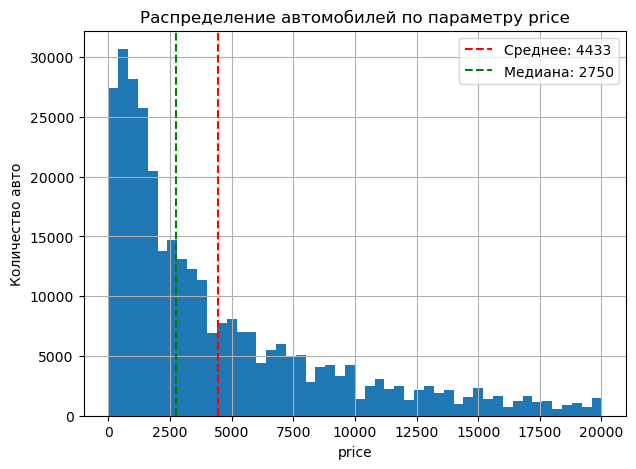

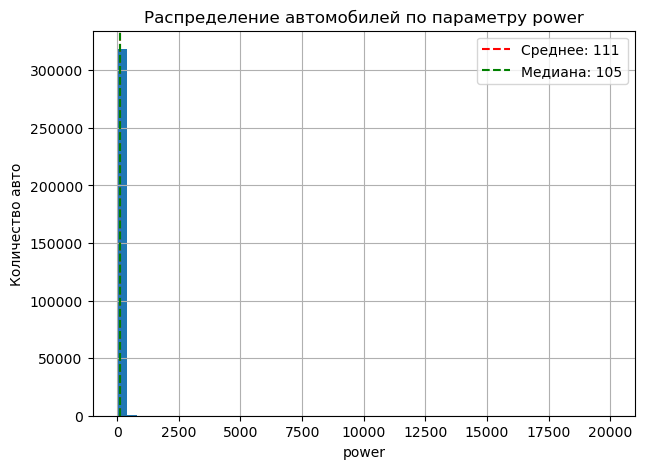

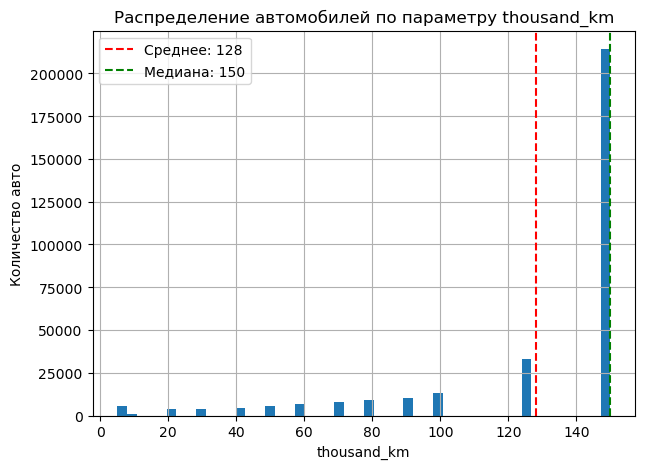

In [72]:
cols = ['price', 'power', 'thousand_km']
for i, c in enumerate(cols):
    mean = round(data[c].mean())
    median = round(data[c].median())
    
    data[c].hist(bins=50, figsize=(7, 5))
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean}')
    plt.axvline(median, color='g', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median}')
    plt.title(f'Распределение автомобилей по параметру {c}')
    plt.xlabel(f'{c}')
    plt.ylabel('Количество авто')
    plt.legend()
    plt.show()

Распределение цены авто положительно ассиметрично (с перекосом вправо) со средним значением 4433 евро и медианой 2750 евро. При этом имеются автомобили с нулевой и низкой стоимостью:

In [74]:
print(f'price = 0: {len(data[data['price'] == 0]) * 100 / len(data)}. price < 51 евро: {len(data[data['price'] < 51]) * 100 / len(data)}')

price = 0: 2.9088572682254124. price < 51 евро: 3.4786560521532


In [75]:
data = data[data['price'] > 50]

Таких значений мало (3,5%) поэтому они были удалены.
<br>Если по распределению цены картина ясная, то по мощности и пробегу построенные графики непоказательны. По мощности график такой из-за наличия выбросов. Устраним их

In [77]:
print(f'power >= 300: {len(data.query('power >= 300')) * 100 / len(data)}. power = 0: {len(data.query('power == 0')) * 100 / len(data)}')

power >= 300: 1.0553284344446212. power = 0: 9.961001555391753


Видно, что автомобилей с мощностю более 300 л.с всего 1%. При этом строк с нулем в мощности 10%. Высокие значения можно удалить, а нулевые нельзя. Вместо этого нулевые значения по мощности заменим медианным значением по модели автомобиля:

In [79]:
data = data.query('power < 300')

In [80]:
data.query('power == 0').head(4)

,price,vehicle_type,reg_year,gearbox,power,model,thousand_km,reg_month,fuel_type,brand,repaired,postal_code
0,480,sedan,1993,manual,0,golf,150,0,petrol,volkswagen,unknown,704
15,450,small,1910,manual,0,ka,5,0,petrol,ford,unknown,241
32,245,sedan,1994,manual,0,golf,150,2,petrol,volkswagen,no,441
37,1500,bus,2016,manual,0,kangoo,150,1,gasoline,renault,no,464


In [81]:
data.loc[data['power'] == 0,'power'] = data.groupby(['model', 'brand'])['power'].transform(lambda x: int(x.median()))
data.iloc[[0, 14, 29, 34]]   # для проверки

,price,vehicle_type,reg_year,gearbox,power,model,thousand_km,reg_month,fuel_type,brand,repaired,postal_code
0,480,sedan,1993,manual,98,golf,150,0,petrol,volkswagen,unknown,704
15,450,small,1910,manual,60,ka,5,0,petrol,ford,unknown,241
32,245,sedan,1994,manual,98,golf,150,2,petrol,volkswagen,no,441
37,1500,bus,2016,manual,75,kangoo,150,1,gasoline,renault,no,464


In [82]:
data.query('model == "golf"')['power'].median()   # для проверки 

98.0

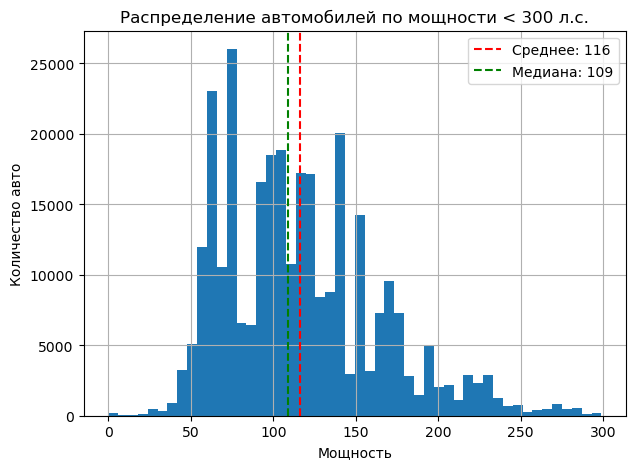

In [83]:
mean = round(data['power'].mean())
median = round(data['power'].median())
    
data['power'].hist(bins=50, figsize=(7, 5))
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean}')
plt.axvline(median, color='g', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median}')
plt.title(f'Распределение автомобилей по мощности < 300 л.с.')
plt.xlabel('Мощность')
plt.ylabel('Количество авто')
plt.legend();

Распределение по мощности имеет приближенно нормальное распределение со средним значением 116 и медианой 109.
<br>Посмотрим на распределение медианной цены и количества автомобилей в зависимости от пробега:

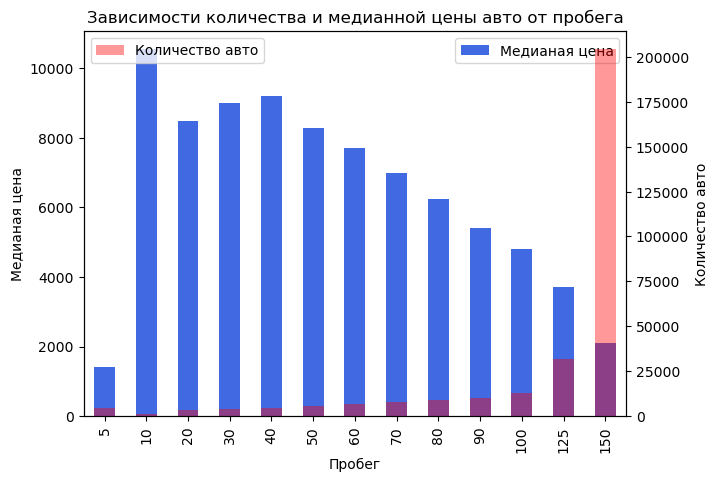

In [85]:
temp = data.groupby('thousand_km')['price'].agg(['median', 'count'])
fig, ax = plt.subplots(figsize=(7, 5))

temp['median'].plot(kind='bar', color='royalblue', label='Медианая цена', ax=ax)
ax.set_xlabel('Пробег')
ax.set_ylabel('Медианая цена')
plt.legend()

ax2 = ax.twinx()
temp['count'].plot(kind='bar', color='r', label='Количество авто', ax=ax2, alpha=0.4)
ax2.set_ylabel('Количество авто')
plt.legend()
plt.title('Зависимости количества и медианной цены авто от пробега')

plt.show()

Наблюдается тенденция: с ростом пробега цена падает (что логично). Имеющееся исключение (5 км) скорее всего связано с некачественным автомобилем и, как следствие, его более низкой цены. Также видно, что с ростом пробега растет и количество автомобилей. Под цифрой 150 тыс.км скорее всего подразумевается 150+ тыс. км (т.к. таких значений очень много).
<br>Построим боксплоты для наглядности:

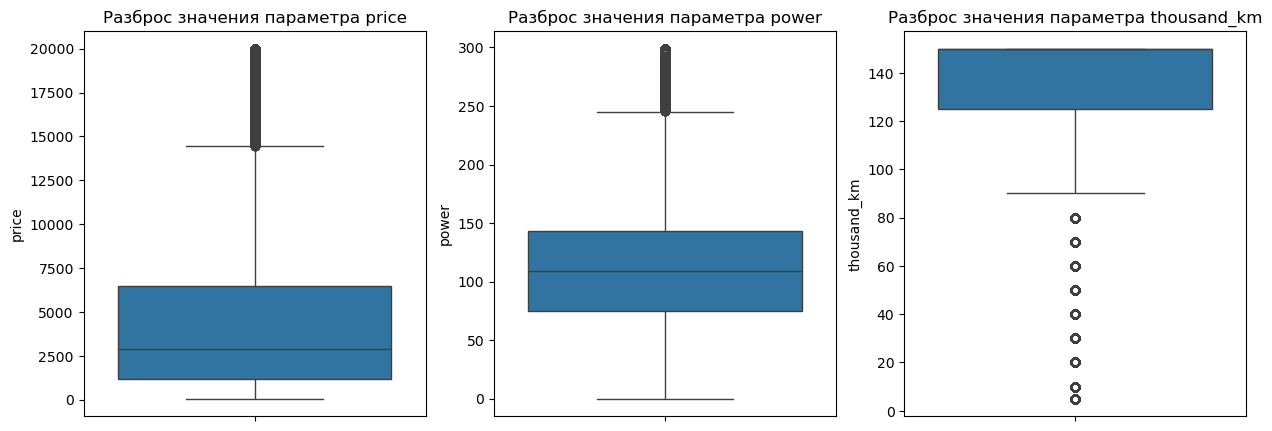

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axe = axes.ravel()

cols = ['price', 'power', 'thousand_km']
for i, c in enumerate(cols):
    sns.boxplot(data=data[c], ax=axe[i]).set(title=f'Разброс значения параметра {c}')
plt.show()

Посмотрим на количество автомобилей в зависимости от значения категориальных признаков: `vehicle_type`, `gearbox`, `fuel_type`, `repaired`:

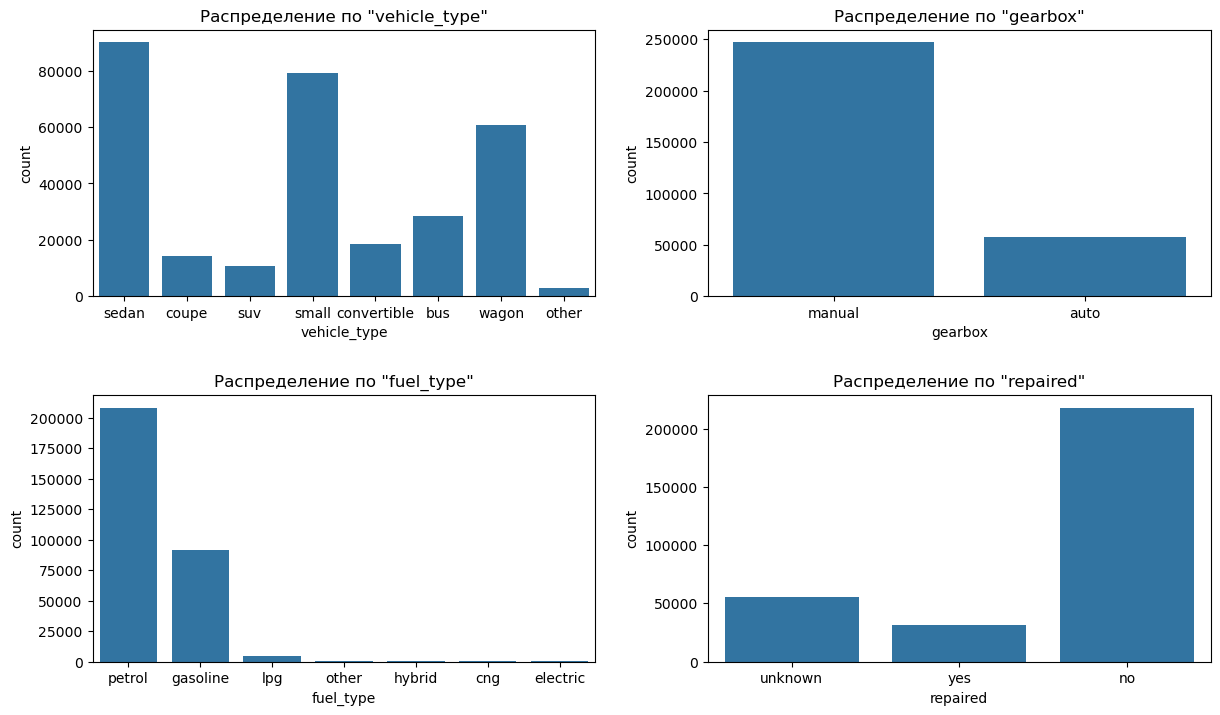

In [89]:
cat_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axe = axes.ravel()
fig.tight_layout(pad=5)
for i, c in enumerate(cat_cols):
    sns.countplot(data = data, x=c, ax=axe[i])
    axe[i].set_xlabel(c)
    axe[i].set_title(f'Распределение по "{c}"')
plt.show()

Наиболее распространенные типы кузова это sedan, small, и wagon. Большинство автомобилей имеют ручную коробку передач, ездят на бензине и не были в ремонте.
<br>Посмотрим, как выглядит медианная цена и количество автомобилей по каждой марке:

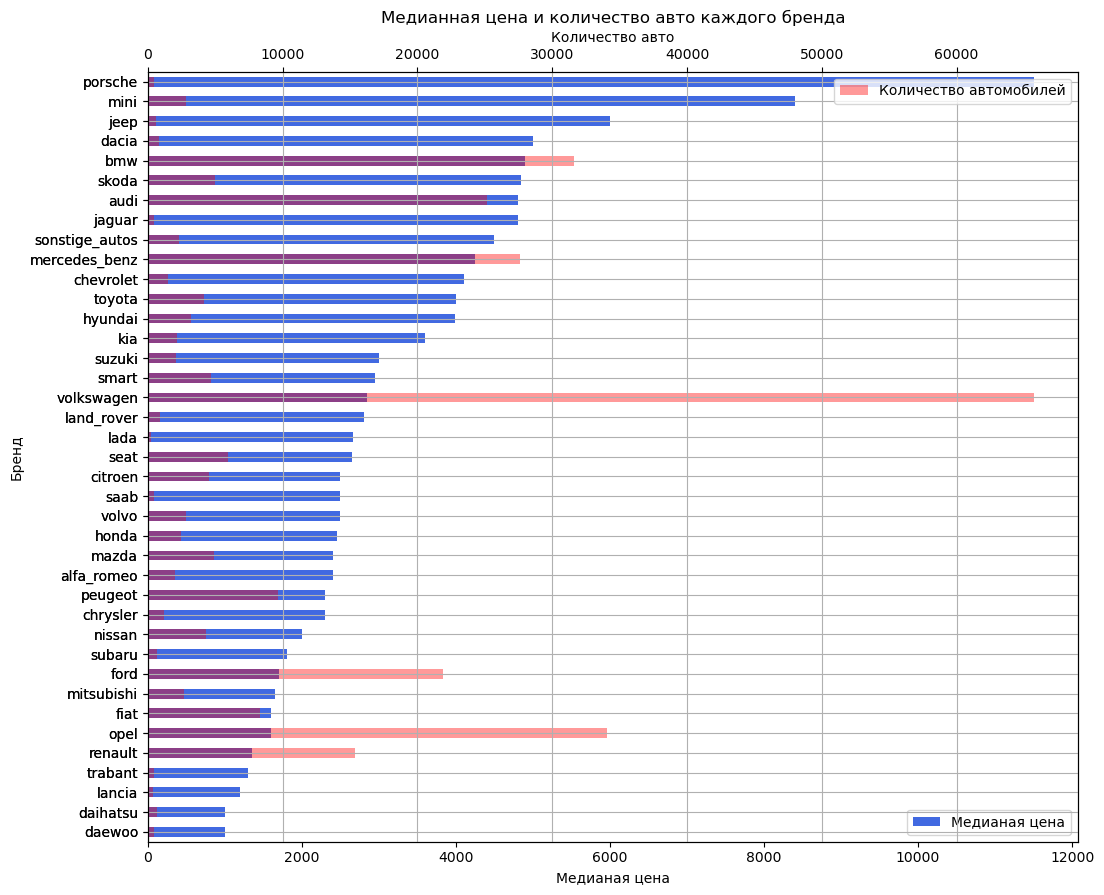

In [91]:
temp = data.groupby('brand')['price'].agg(['median', 'count']).sort_values(by='median')
fig, ax = plt.subplots(figsize=(12, 10))

temp['median'].plot(kind='barh', color='royalblue', label='Медианая цена', ax=ax)
ax.set_xlabel('Медианая цена')
ax.set_ylabel('Бренд')
plt.legend()

ax2 = ax.twiny()
temp['count'].plot(kind='barh', color='r', label='Количество автомобилей', ax=ax2, alpha=0.4, grid=True)
ax2.set_xlabel('Количество авто')
ax2.set_ylabel('')
plt.legend()
plt.title('Медианная цена и количество авто каждого бренда')

plt.show()

Видно, что porsche, mini и jeep стоят дороже всего. При этом самые высокие продажи (свыше 20 тыс. автомобилей) у bmw, audi, mercedes_benz, volkswagen, ford и opel. Можно сделать вывод, что самая большая выручка от продажи авто у немецких производителей: volkswagen, bmw, audi, opel и mercedes_benz.
<br>Посмотрим, какой процент поломок у каждого бренда.

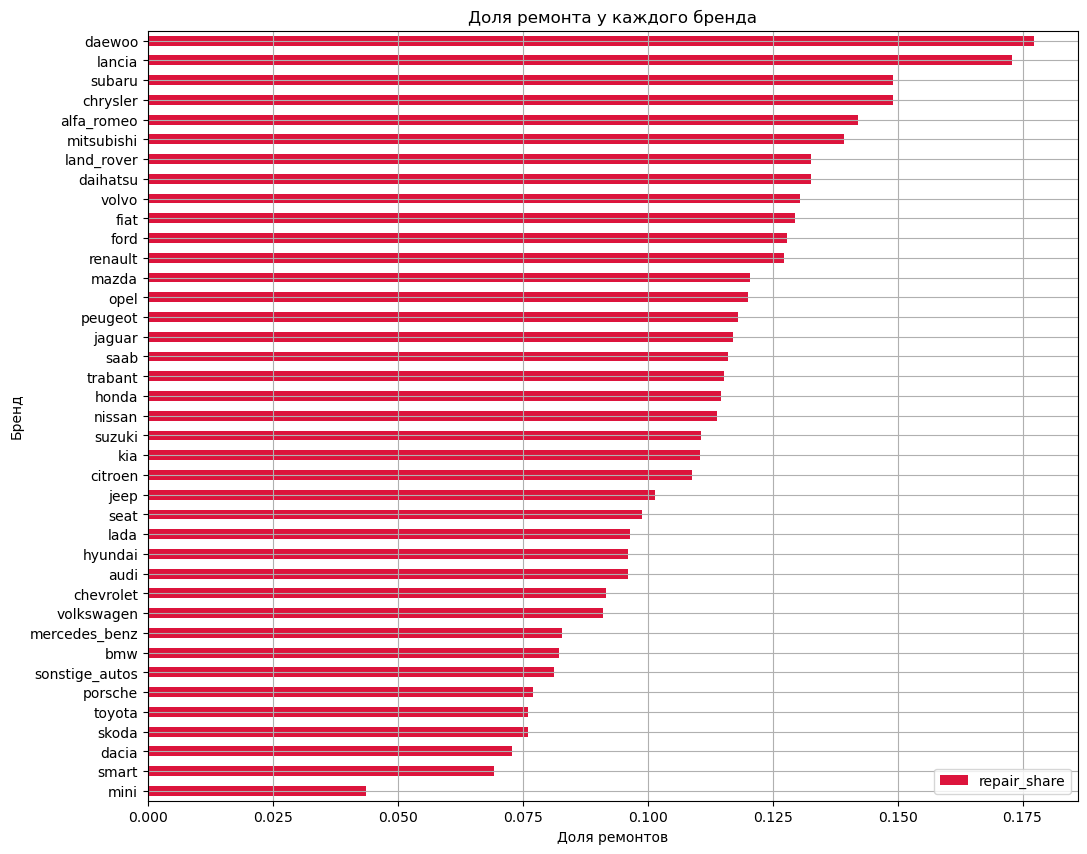

In [93]:
temp = data.pivot_table(index='brand', columns='repaired', values='postal_code', aggfunc='count')
temp['repair_share'] = temp['yes'] / (temp['yes'] + temp['no'] + temp['unknown'])
temp = temp.sort_values(by='repair_share')

fig, ax = plt.subplots(figsize=(12, 10))

temp[['repair_share']].plot(kind='barh', grid=True, color='crimson', ax=ax)
ax.set_xlabel('Доля ремонтов')
ax.set_ylabel('Бренд')
plt.title('Доля ремонта у каждого бренда')
plt.legend();

Самая надежная марка это mini. высокая надежность этого автомобиля и porsche отчасти обясняет их высокую цену. Из компаний с продажами свыше 20 тыс. авто самые ненадежные это ford и opel.
<br>Посмотрим, как выглядит распределение медианной цены в зависимости от кузова автомобиля.

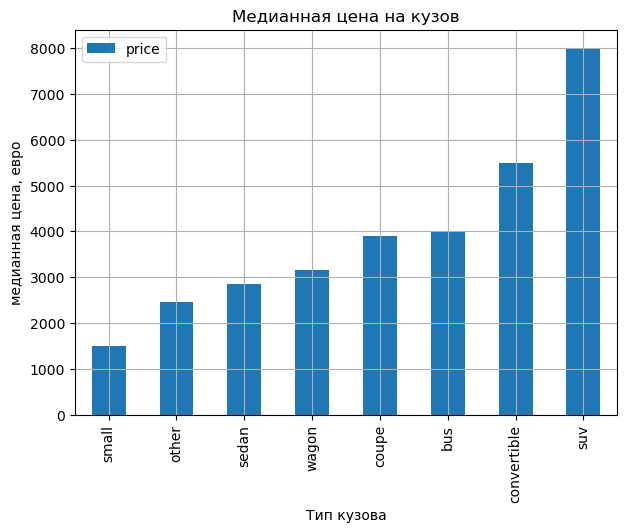

In [95]:
temp = pd.DataFrame(data.groupby('vehicle_type')['price'].median()).sort_values(by='price')

temp.plot(kind='bar', 
          grid=True, 
          figsize=(7, 5),
          title='Медианная цена на кузов',
          xlabel='Тип кузова',
          ylabel='медианная цена, евро');

Small, sedan и wagon имеют довольно низкие цены, чем и объясняется их широкое распространение. В тоже время suv имеет самую высокую цену и при этом таких автомобилей менее всего (исключая other).
<br>Посмотрим, как выглядят плотности распределения авто в зависимости от кузова и проводимого ремонта:

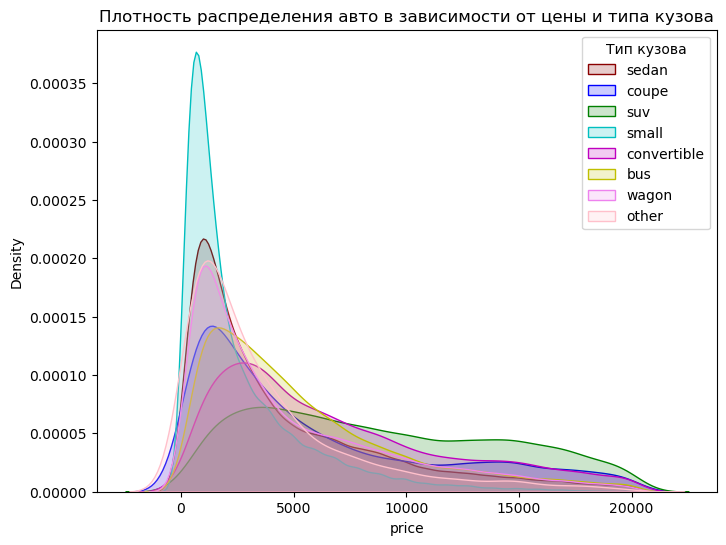

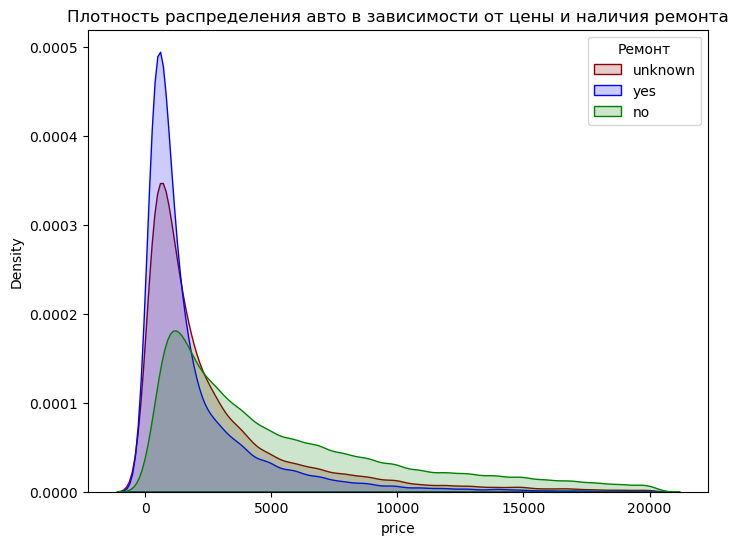

In [97]:
# первый график
veh_type = list(data['vehicle_type'].unique())
colors = ['darkred', 'b', 'g', 'c', 'm', 'y', 'violet', 'pink']
plt.figure(figsize=(8, 6))

for t, i in enumerate(veh_type):
    sns.kdeplot(data.loc[data['vehicle_type'] == i, 'price'], shade=True, color=colors[t], label=i, alpha=.2)

plt.title('Плотность распределения авто в зависимости от цены и типа кузова')
plt.legend(title='Тип кузова')

# второй график
repair = list(data['repaired'].unique())
plt.figure(figsize=(8, 6))

for t, i in enumerate(repair):
    sns.kdeplot(data.loc[data['repaired'] == i, 'price'], shade=True, color=colors[t], label=i, alpha=.2)

plt.title('Плотность распределения авто в зависимости от цены и наличия ремонта')
plt.legend(title='Ремонт')
plt.show()

По графикам видно, что у всех кузовов стоимость большинства автомобилей до 5000 евро. Более стабильная картина только у кузова suv. Интересно, что у купе от 12000 евро есть некоторый подъем по количеству автомобилей. Это связано с большим количеством спортивных автомобилей.
<br>На втором графике стоит заметить, что автомобили с `repaired` == unknown в цене от 2000 евро ближе к тем автомобилям, которые были в ремонте. Поэтому скорее всего у автомобилей без указания наличия ремонта он все-таки был (но, возможно, несерьезный).
<br>Построим распределение цены автомобиля в зависимости от года регистрации.

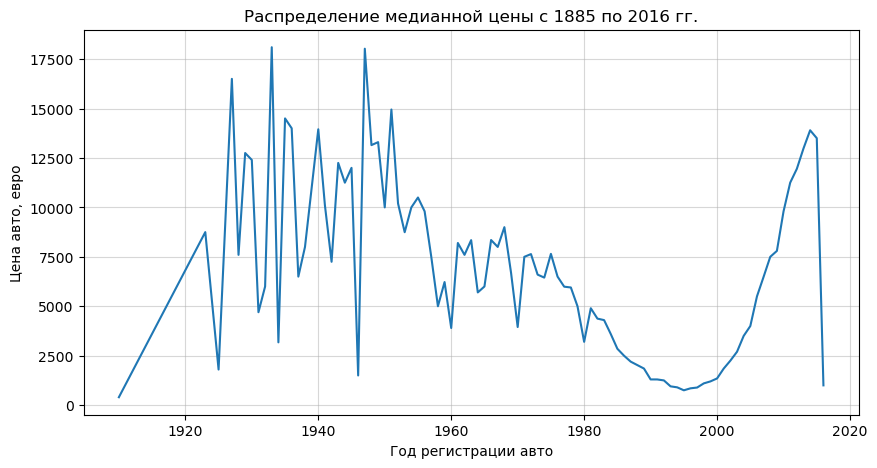

In [99]:
temp = data.groupby('reg_year')['price'].median()

plt.figure(figsize=(10, 5))
plt.plot(temp.index, list(temp))
plt.title('Распределение медианной цены с 1885 по 2016 гг.')
plt.xlabel('Год регистрации авто')
plt.ylabel('Цена авто, евро')
plt.grid(axis='both', alpha=.5);

Видно, что примерно до 1971 года данные от года к году сильно различаются. Скорее всего это связано с тем, что в те времена автомобилей (либо записей о них в БД) было сильно меньше и цена сильно варировалась. Кроме этого наблюдается сильное падение медианной цены в 2016 году. Это, скорее всего связано с большим количеством автомобилей, которые были зарегестрированны в 2016 году и еще не попали в БД (ввиду ограничения даты выгрузки 2016 годом).

In [101]:
print(len(data.query('reg_year >= 1885 & reg_year < 1971')), len(data.query('reg_year >= 1885 & reg_year < 1971')) *100 / len(data))

1261 0.41383474833530787


Всего 1261 автомобиля было зарегестрированно с 1885 по 1970 год. Поскольку эти записи врядли улучшат модель и их мало (ок. 0,4%), то удалим данные записи:

In [103]:
len(data)

304711

In [104]:
data = data.query('1971 <= reg_year <= 2016')

In [105]:
len(data)

303450

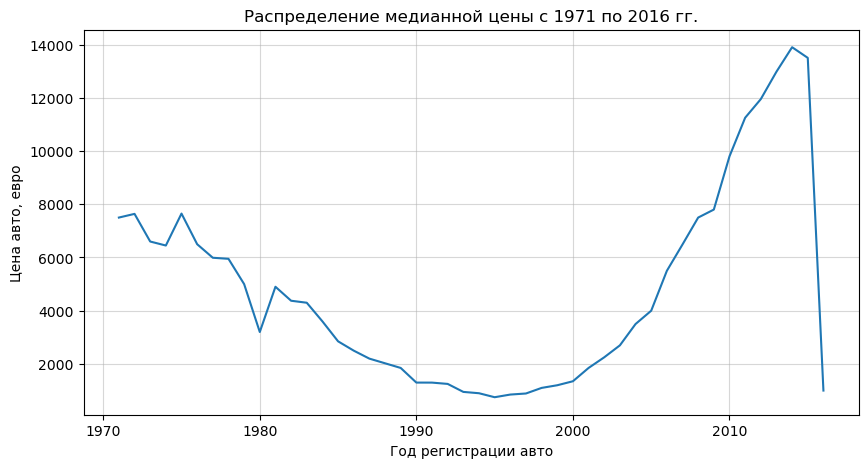

In [106]:
temp = data.groupby('reg_year')['price'].median()

plt.figure(figsize=(10, 5))
plt.plot(temp.index, list(temp))
plt.title('Распределение медианной цены с 1971 по 2016 гг.')
plt.xlabel('Год регистрации авто')
plt.ylabel('Цена авто, евро')
plt.grid(axis='both', alpha=.5);

Посмотрим, сколько данных осталось от изначального количества (354369 строк):

In [108]:
print(f'Осталось {len(data) * 100 / 354369} % от изначального количества данных')

Осталось 85.63107946801216 % от изначального количества данных


Выполним проверку на корреляцию:

In [110]:
interval_cols = list(data._get_numeric_data().columns)
phik_overview = data.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape) 

(12, 12)


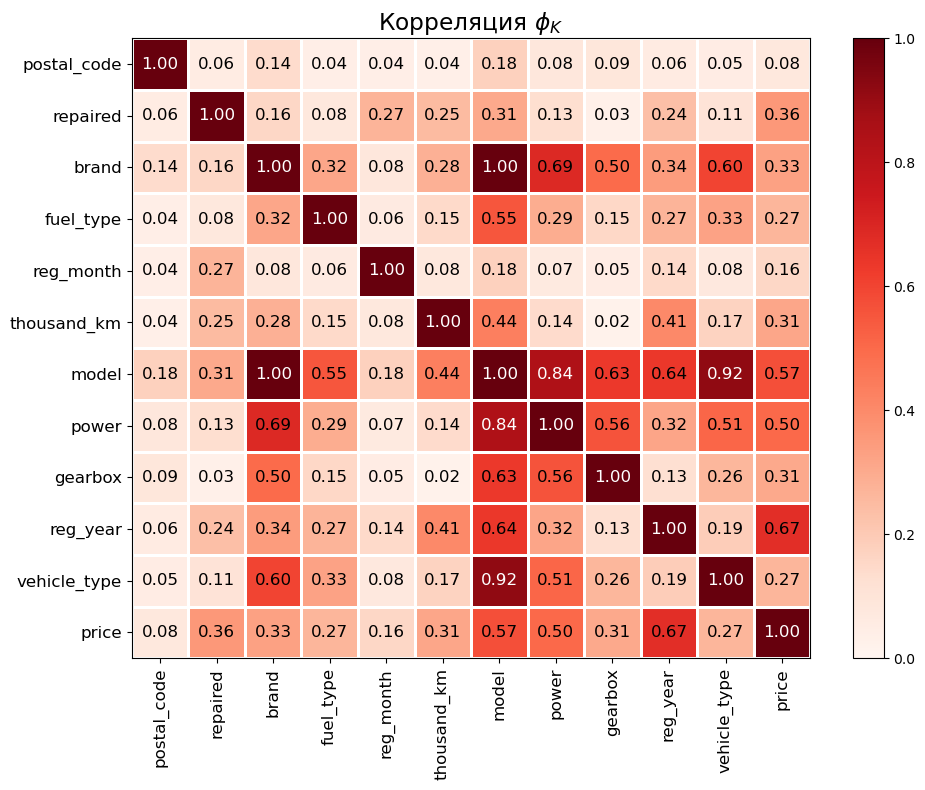

In [111]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.2,
    figsize=(10, 8)) 

Заметна высокая корреляция колонки `model` с прочими признаками: `brand`, `vehicle_type`, `power`. Важно заметить, что пропуски и аномальные значения в колонках `vehicle_type` и `power` заполнялись на основании `model` поэтому сильно коррелируют. Но все эти признаки, как будет видно далее, сильно влияют на модель, поэтому убирать их не будем. 

**Вывод**
<br> Распределение цены авто положительно ассиметрично (с перекосом вправо) со средним значением 4433 евро и медианой 2750 евро. При этом имеются автомобили с нулевой и низкой стоимостью. Поскольку таких значений мало (3,5%), то они были удалены. Автомобилей с мощностю более 300 л.с всего 1%. При этом строк с нулем в мощности 10%. Высокие значения были удалены, а низкие заменены на медианы по модели автомобиля.
<br> Распределение по мощности имеет приближенно нормальное распределение со средним значением 116 и медианой 109. Также наблюдается тенденция: с ростом пробега цена падает (что логично). Имеющееся исключение (5 км) скорее всего связано с некачественным автомобилем и, как следствие, его более низкой ценой. Также видно, что с ростом пробега растет и количество автомобилей. Под цифрой 150 тыс.км скорее всего подразумевается 150+ тыс. км (т.к. таких значений очень много). Наиболее распространенные типы кузова это sedan, small, и wagon. Большинство автомобилей имеют ручную коробку передач, ездят на бензине и не были в ремонте. Small, sedan и wagon имеют довольно низкие цены, чем и объясняется их широкое распространение. В тоже время suv имеет самую высокую цену и при этом таких автомобилей менее всего (исключая other).
<br>Из проведенного анализа видно, что porsche, mini и jeep стоят дороже всего. При этом самые высокие продажи (свыше 20 тыс. автомобилей) у bmw, audi, mercedes_benz, volkswagen, ford и opel. Можно сделать вывод, что самая большая выручка у немецких производителей: volkswagen, bmw, audi, opel и mercedes_benz. А самые надежные марки это mini, smart и porsche, что отчасти обясняет высокую цену на mini и porsche. Из компаний с продажами свыше 20 тыс. авто самые ненадежные это ford и opel. 
<br>Примерно до 1971 года данные от года к году сильно различаются. Скорее всего это связано с тем, что в те времена автомобилей (либо записей о них в БД) было сильно меньше и цена сильно варировалась. Кроме этого наблюдается сильное падение медианной цены в 2016 году. Это, скорее всего связано с большим количеством автомобилей, которые были зарегестрированны в 2016 году и еще не попали в БД (ввиду ограничения даты выгрузки 2016 годом. Всего 1288 автомобиля было зарегестрированно с 1885 по 1970 год. Поскольку эти записи не улучшат модель и их мало (ок. 0,4%), то они были удалены. В результате выполненных сокращений осталось примерно 85,6% от изначального количества данных.
<br>Никакие данные между собой сильно не коррелируют. Целевой признак `price` сильнее всего коррелирует с `reg_year`, `power` и `model`.

## Подготовка данных для моделирования

In [115]:
# деление на тренировочную, тестовую и валидационную выборки
X_train_1, X_test, y_train_1, y_test = train_test_split(data.drop('price', axis=1), 
                                                        data['price'], 
                                                        test_size=0.2, 
                                                        random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train_1, 
                                                  y_train_1, 
                                                  test_size=0.25, 
                                                  random_state=RANDOM_STATE)

print('train size:', X_train.shape, ' val size:', X_val.shape, ' test size:', X_test.shape)

train size: (182070, 11)  val size: (60690, 11)  test size: (60690, 11)


In [116]:
cat_columns = ['vehicle_type', 'gearbox', 'fuel_type',   # численные и категориальные колонки
               'model', 'brand', 'repaired']
    
num_columns = ['reg_year', 'power', 'thousand_km',
               'reg_month', 'postal_code']                

## Обучение и анализ моделей

В качестве моделей будем использовать: LinearRegression, RandomForestRegressor, LightGBMRegressor и CatBoostRegressor.
<br>Для обучения модели и предикта, а также для визулизации известных значений и предсказаний с помощью гистограмм напишем функцию predict_price:

In [119]:
# создадим датафрейм для сведения результатов моделей (время обучения, RMSE)
cols = ['time', 'RMSE']
df_models = pd.DataFrame(columns=cols)

# создадим датафрейм для сведения предсказаний моделей
df_preds = pd.DataFrame()
df_preds['y_val'] = y_val

In [120]:
def predict_price(model, name):
    
    '''Функция для расчета RMSE модели (model) и внесение результата в датафрейм df_models'''
    
    # обучение модели с оценкой времени, предсказание цены и расчет метрики RMSE
    start_time = timeit.default_timer()   
    model.fit(X_train_prep, y_train)    
    time = round(timeit.default_timer() - start_time, 2)
    print('Время на обучение, сек: ', time)
    
    pred = model.predict(X_val_prep)
    df_preds[name] = pred
    
    rmse = round(((mean_squared_error(y_val, pred))**0.5), 2)
    print('RMSE:                   ', rmse)
    df_models.loc[len(df_models)] = [time, rmse]
    
    # гистограммы распределения известной цены и предсказания
    y_test.hist(bins=50, label='Известная цена', figsize=(7, 5))
    pd.Series(pred).hist(bins=50, label='Предсказанная цена', alpha=0.5)
    
    mean = round(pd.Series(pred).mean())
    median = round(pd.Series(pred).median())
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1.5, label=f'Среднее модели: {mean}')
    plt.axvline(median, color='g', linestyle='dashed', linewidth=1.5, label=f'Медиана модели: {median}')

    plt.xlabel('Цена')
    plt.ylabel('Количество')
    plt.title('Распределение истинной и предсказанной цены')
    plt.legend();

In [121]:
def feature_importanses(model):

    '''Функция для вывода 5 самых важных признаков модели'''
    
    features = {'feature': X_train_prep.columns, 'weight': model.feature_importances_}
    return pd.DataFrame(features).sort_values(by='weight', ascending=False).head(5)

In [122]:
def get_rmse(y_val, pred):
    
    '''Функция для расчета RMSE'''
    
    return (mean_squared_error(y_val, pred))**0.5

# сразу создадим метрику RMSE
RMSE = make_scorer(get_rmse, greater_is_better=False)

In [123]:
def show_rmse():
    
    '''Показывает RMSE лучшей модели'''
    
    print('RMSE лучшей модели на тренировочной выборке:', -best_model.best_score_)

**Линейная регрессия:**

In [125]:
# Подготовка данных для линейной регресии
ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

data_prep = ColumnTransformer([('ohe', ohe_pipe, cat_columns),
                               ('num', StandardScaler(), num_columns)], remainder='passthrough')

X_train_prep = pd.DataFrame(data=data_prep.fit_transform(X_train), 
                            columns=data_prep.get_feature_names_out())

X_val_prep = pd.DataFrame(data=data_prep.transform(X_val), 
                            columns=data_prep.get_feature_names_out())

In [126]:
model_lin = LinearRegression()   # инициализация модели

Время на обучение, сек:  1.32
RMSE:                    2567.37


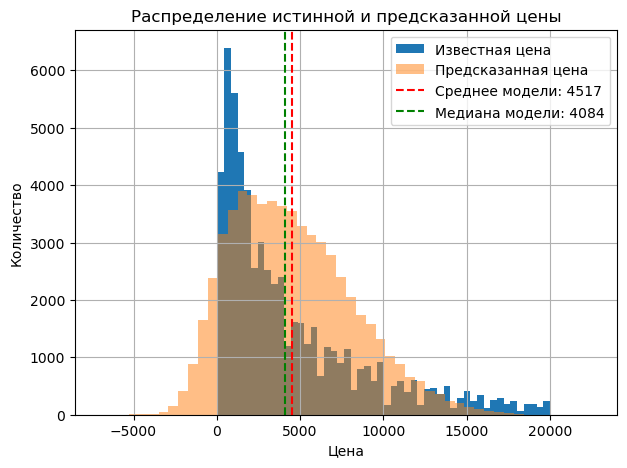

In [127]:
predict_price(model_lin, 'lin')

Как видно из гистограммы, линейная регрессия в некоторых случаях дает отрицательную стоимость автомобиля. Также она лучше подойдет для предсказания признака, который распределен нормально. Для ассиметричных распределений линейная модель не подойдет.

**RandomForestRegressor**

In [130]:
pipe_final = Pipeline([('preprocessor', data_prep),
                       ('models', RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=30))])

Будем искать лучшую комбинацию среди параметров: max_features: 5, 10; min_samples_split: 5, 10. Для ускорения расчета n_estimators примем равным 30 (для дефолтных 100 результат будет лучше, но обучение перебором параметров намного дольше).

In [132]:
# Список параметров модели для сравнения
param_grid = [
    {'models': [RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=30)],
     'models__max_features': [5, 10],
     'models__min_samples_split': [5, 10],
     'preprocessor__num': [StandardScaler(), 'passthrough']} 
]

In [133]:
# Выбор лучшей модели и оценка по метрике RMSE
best_model = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=RMSE,
    n_jobs=-1)

In [134]:
best_model.fit(X_train, y_train)

/home/ilya/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ilya/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ilya/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ilya/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ilya/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'fuel_type',
                                                                          'model',
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['reg_year',
                                                                          'power',
                                                                          'thousand_km',
                                                                          'reg...
                                       ('models',
                                        RandomForestRegressor(n_estimators=30,
                                                              random_state=1))]),
             n_jobs=-1,
             param_grid=[{'models': [RandomForestRegressor(n_estimators=30,
                                                           random_state=1)],
                          'models__max_features': [5, 10],
                          'models__min_samples_split': [5, 10],
                          'preprocessor__num': [StandardScaler(),
                                                'passthrough']}],
             scoring=make_scorer(get_rmse, greater_is_better=False, response_method='predict'))

In [135]:
show_rmse()

RMSE лучшей модели на тренировочной выборке: 1696.6245374359423


In [136]:
# инициируем модель снова с лучшими параметрами для оценки времени обучения
model_rfr = RandomForestRegressor(max_features=10, min_samples_split=5, random_state=RANDOM_STATE)

Время на обучение, сек:  30.57
RMSE:                    1637.54


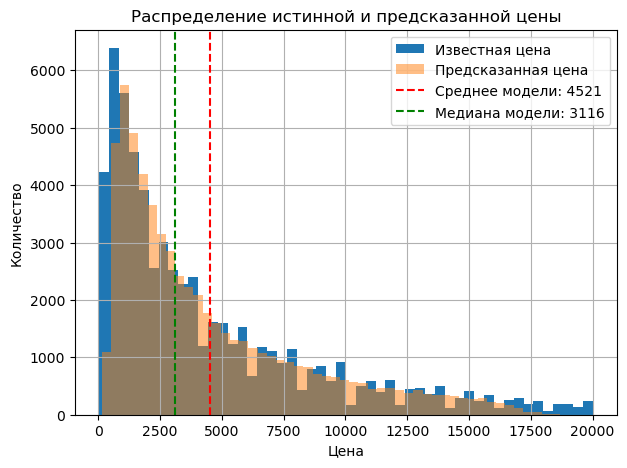

In [137]:
predict_price(model_rfr, 'rfr')

In [138]:
feature_importanses(model_rfr)

,feature,weight
307,num__reg_year,0.291109
308,num__power,0.152890
309,num__thousand_km,0.133071
311,num__postal_code,0.037444
310,num__reg_month,0.032787


**LGBMRegressor**

In [140]:
X_train_prep = X_train.copy()
X_val_prep = X_val.copy()

In [141]:
X_train_prep[cat_columns] = X_train_prep[cat_columns].astype('category')    # смена типов данных для модели
X_val_prep[cat_columns] = X_val_prep[cat_columns].astype('category')

In [142]:
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182070 entries, 288648 to 324767
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  182070 non-null  category
 1   reg_year      182070 non-null  int16   
 2   gearbox       182070 non-null  category
 3   power         182070 non-null  int64   
 4   model         182070 non-null  category
 5   thousand_km   182070 non-null  int16   
 6   reg_month     182070 non-null  int8    
 7   fuel_type     182070 non-null  category
 8   brand         182070 non-null  category
 9   repaired      182070 non-null  category
 10  postal_code   182070 non-null  int16   
dtypes: category(6), int16(3), int64(1), int8(1)
memory usage: 5.2 MB


In [143]:
pipe_final = Pipeline([('models', RandomForestRegressor(random_state=RANDOM_STATE))])

In [144]:
# Список параметров модели для сравнения
param_grid = [
    {'models': [LGBMRegressor()],
     'models__n_estimators': [1000, 1500],
     'models__max_depth': [1, 10, 15],
     'models__learning_rate': [0.1, 0.2]} 
]

In [145]:
# Выбор лучшей модели и оценка по метрике RMSE
best_model = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=RMSE,
    n_jobs=-1)

In [146]:
best_model.fit(X_train_prep, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 145656, number of used features: 11
[LightGBM] [Info] Start training from score 4513.136060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('models',
                                        RandomForestRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMRegressor()],
                          'models__learning_rate': [0.1, 0.2],
                          'models__max_depth': [1, 10, 15],
                          'models__n_estimators': [1000, 1500]}],
             scoring=make_scorer(get_rmse, greater_is_better=False, response_method='predict'))

In [147]:
best_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('models',
                                        RandomForestRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMRegressor()],
                          'models__learning_rate': [0.1, 0.2],
                          'models__max_depth': [1, 10, 15],
                          'models__n_estimators': [1000, 1500]}],
             scoring=make_scorer(get_rmse, greater_is_better=False, response_method='predict'))

In [148]:
show_rmse()

RMSE лучшей модели на тренировочной выборке: 1540.8239028986663


In [149]:
# инициируем модель снова с лучшими параметрами для оценки времени обучения
model_lgbm = LGBMRegressor(max_depth=15, n_estimators=1500)   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 182070, number of used features: 11
[LightGBM] [Info] Start training from score 4509.691146
Время на обучение, сек:  4.36
RMSE:                    1531.59


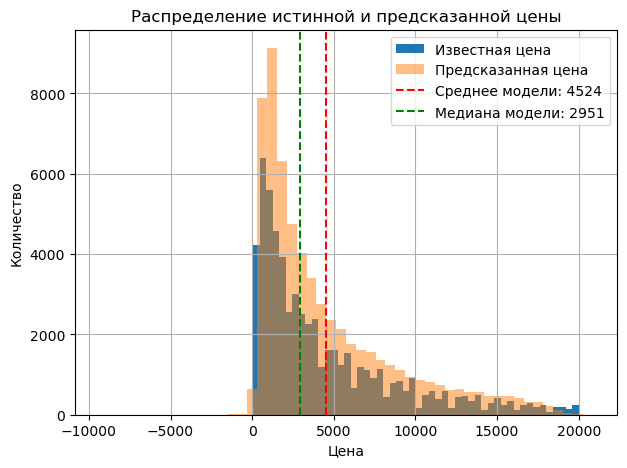

In [150]:
predict_price(model_lgbm, 'lgbm')

In [151]:
feature_importanses(model_lgbm)

,feature,weight
10,postal_code,9539
1,reg_year,8186
3,power,8163
4,model,5263
6,reg_month,4626


**CatBoostRegressor**

In [153]:
# Подготовка данных
X_train_prep = pd.DataFrame(data=data_prep.fit_transform(X_train), 
                            columns=data_prep.get_feature_names_out())

X_val_prep = pd.DataFrame(data=data_prep.transform(X_val), 
                          columns=data_prep.get_feature_names_out())

In [154]:
# Выбор лучшей модели и оценка по метрике RMSE (без кроссвалидации для экономии времени)
depth = [10, 13]

for i in depth:
    model = CatBoostRegressor(silent=True, max_depth=i)

    print('Глубина: ', i)  
    model.fit(X_train_prep, y_train)    

    pred = model.predict(X_val_prep)
    
    rmse = round(((mean_squared_error(y_val, pred))**0.5), 2)
    print('RMSE:', rmse)
    print()

Глубина:  10
RMSE: 1540.02

Глубина:  13
RMSE: 1529.86



In [155]:
# инициируем модель снова с лучшими параметрами для оценки времени обучения
model_cat = CatBoostRegressor(silent=True, max_depth=13)

Время на обучение, сек:  45.27
RMSE:                    1529.86


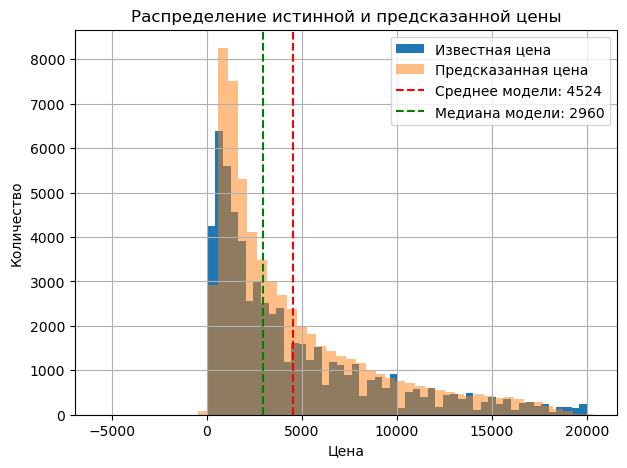

In [156]:
predict_price(model_cat, 'cat')

In [157]:
feature_importanses(model_cat)

,feature,weight
307,num__reg_year,30.299763
308,num__power,20.853786
309,num__thousand_km,10.192314
310,num__reg_month,3.142469
311,num__postal_code,2.744238


In [158]:
df_models['model'] = ['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'] 
df_models

,time,RMSE,model
0,1.32,2567.37,LinearRegression
1,30.57,1637.54,RandomForestRegressor
2,4.36,1531.59,LGBMRegressor
3,45.27,1529.86,CatBoostRegressor


Из таблицы с результатми моделей видно, что наиболее быстрая и наименее точная модель - линейная регрессия. Она не укладывается в необходимые 2500 очков RMSE.
<br>LGBM с параметрами: n_estimators = 1500, max_depth = 15 довольно точная модель (RMSE = 1531,59) и быстрая. 
<br>CatBoost с параметром max_depth = 13 самая точная (RMSE = 1529,9) но значительно медленнее LGBM. Для расчета на тестовых данных будем использовать LGBM.
<br>RandomForestRegressor хуже (RMSE = 1637,5) и медленне, чем LGBM, но быстрее, чем CatBoost.
<br>Для RandomForestRegressor, LGBM и CatBoost самые влиятельные признаки это год регистрации, мощность, пробег и почтовый код.
<br>Интересно, что LGBM и CatBoost как и линейная регрессия иногда дает отрицательную цену автомобиля. Посмотрим, повлияет ли замена отрицательных значений на принятую нижнюю границу датасета (50 евро): 

In [160]:
df_preds

,y_val,lin,rfr,lgbm,cat
35478,6500,6234.037579,6667.939365,6833.054552,6832.727961
287032,950,2709.327702,1736.562389,1348.364537,1816.338461
5860,3000,3885.546500,3340.697492,3241.148542,3039.013796
195875,1900,2741.296252,2085.430139,1268.071990,1596.922225
182406,3200,4292.995686,3871.104611,3520.356808,3384.753896
...,...,...,...,...,...
258036,2200,3294.161537,3509.809855,2888.631239,2873.776005
329985,5390,6612.374917,5188.701147,4975.596881,5591.479987
306657,1350,1981.969465,1331.396631,1284.075688,1352.570245
295947,2500,915.200053,1196.079643,705.651147,813.784107


In [161]:
print(f'Количество пропусков у LGBM: {len(df_preds.query('lgbm < 0'))}. Количество пропусков у cat: {len(df_preds.query('cat < 0'))}')

Количество пропусков у LGBM: 88. Количество пропусков у cat: 67


In [162]:
df_preds['new_pred_lgbm'] = np.where(df_preds['lgbm'] < 0, 50, df_preds['lgbm'])
df_preds['new_pred_cat'] = np.where(df_preds['cat'] < 0, 50, df_preds['cat'])

In [163]:
for i in ['new_pred_lgbm', 'new_pred_cat']:
    rmse = round(((mean_squared_error(df_preds['y_val'], df_preds[i]))**0.5), 2)
    print('RMSE: ', rmse)

RMSE:  1529.04
RMSE:  1528.72


Из-за такой замены значение метрики почти не изменилось (RMSE у обоих моделей слабо уменьшилась). Это потому что мало автомобилей, которым LGBM и CatBoost предсказывает отрицательную цену. Причем LGBM предсказывает больше отрицательных автомобилей, то и прирост в метрике у нее значительнее.

Проверим, какая из трех моделей оказалась ближе к истине по отношению к каждому значению:

In [166]:
# колонка с указанием модели, которая оказалась ближе всех к истине
df_preds['best_price'] = np.where(
    (abs(df_preds['rfr'] - df_preds['y_val']) < abs(df_preds['lgbm'] - df_preds['y_val'])) & 
    (abs(df_preds['rfr'] - df_preds['y_val']) < abs(df_preds['cat'] - df_preds['y_val'])), 'rfr', 
    np.where(
        (abs(df_preds['lgbm'] - df_preds['y_val']) < abs(df_preds['rfr'] - df_preds['y_val'])) & 
        (abs(df_preds['lgbm'] - df_preds['y_val']) < abs(df_preds['cat'] - df_preds['y_val'])), 'lgbm', 'cat'
            )
)

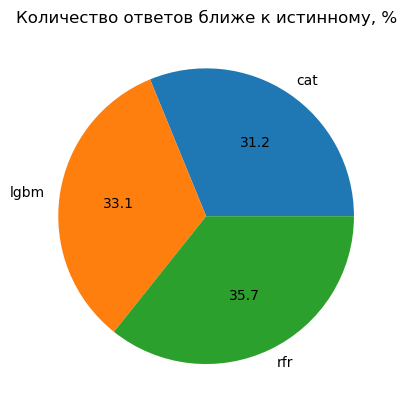

In [167]:
temp = df_preds.pivot_table(index='best_price', values='cat', aggfunc='count')
plt.pie(temp['cat'], autopct='%.1f', labels=temp.index)
plt.title('Количество ответов ближе к истинному, %');

Видно, что модель RandomForestRegressor оказалась ближе к истине в 35,7% случаев, но при этом общий результат этой модели хуже, чем у LGBM и CatBoost. Скорее всего это связано с тем, что LGBM и  CatBoost лучше умеют работать с выбросами.

**Расчет цены авто на тестовых данных при помощи модели LGBM**

In [170]:
X_test[cat_columns] = X_test[cat_columns].astype('category')

In [171]:
pred = model_lgbm.predict(X_test)
rmse = round(((mean_squared_error(y_test, pred))**0.5), 2)
print('RMSE лучшей модели на тестовых данных:', rmse, '< 2500')

RMSE лучшей модели на тестовых данных: 1516.2 < 2500


**Вывод**
<br>Для сравнения были использованы 4 модели: LinearRegression, RandomForestRegressor, LightGBMRegressor и CatBoostRegressor.
<br>В результате обучения моделей выяснилось, что наиболее быстрая и наименее точная модель - линейная регрессия. Она не укладывается в необходимые 2500 очков RMSE. Линейная регрессия в некоторых случаях дает отрицательную стоимость автомобиля. Также она лучше подойдет для предсказания признака, который распределен нормально. Для ассиметричных распределений линейная модель не подойдет.
<br>LGBM с параметрами: n_estimators = 1500, max_depth = 15 довольно точная модель (RMSE = 1531,59) и быстрая. 
<br>CatBoost с параметром max_depth = 13 самая точная (RMSE = 1529,9) но значительно медленнее LGBM. Для расчета на тестовых данных будем использовать LGBM.
<br>RandomForestRegressor хуже (RMSE = 1637,5) и медленне, чем LGBM, но быстрее, чем CatBoost.
<br>Интересно, что LGBM и CatBoost как и линейная регрессия иногда дает отрицательную цену автомобиля. Замена значения отрицательных предсказаний на 50 евро (нижняя граница возможной стоимости в принятом датасете) почти не улучшает метрику (RMSE у обоих моделей уменьшилась менее, чем на 1). Это потому что мало автомобилей, которым LGBM и CatBoost предсказывает отрицательную цену. У CatBoost отрицательных предсказаний больше, поэтому прирост от их замены немного выше.
<br>Также в ходе работы выяснилось, что RandomForestRegressor оказалась ближе к истиной стоимости в 38% случаев, но при этом общий результат этой модели хуже, чем у LGBM и CatBoost. Скорее всего это связано с тем, что LGBM и особенно CatBoost лучше умеют работать с выбросами.

## Вывод по работе

<br>**Информация о данных**
<br> Представленный датасет состоит из 16 колонок (7шт. типа int64 и 9 шт. типа object) и 354369 строк, занимает много памяти (43,3+ mb). Кроме этого имеет 6828 дубликатов, пропущенные значения в колонках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`, неестественные значения в колонках `Price`, `RegistrationYear`, `Power`, `RegistrationMonth`, даты в формате object.
<br> **Предобработка данных**
<br> В результате выполненной предобработки названия колонок приведены к более приемлемому виду. Дубликаты, колонки, которые не могут улучшить модель (`pictures`, `date_crawled`, `date_created`, `last_seen`), были удалены. Неявные дубликаты были устранены. Форматы числовых колонок были преведены к более легкому типу. В результате занимаемый объем датасета сократилсся почти на 39%. Пропуски в колонках `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired` заполнены.
<br> **EDA**
<br> Распределение цены авто положительно ассиметрично (с перекосом вправо) со средним значением 4433 евро и медианой 2750 евро. При этом имеются автомобили с нулевой и низкой стоимостью. Поскольку таких значений мало (3,5%), то они были удалены. Автомобилей с мощностю более 300 л.с всего 1%. При этом строк с нулем в мощности 10%. Высокие значения были удалены, а низкие заменены на медианные значения по модели.
<br> Распределение по мощности имеет приближенно нормальное распределение со средним значением 107 и медианой 105. Также наблюдается тенденция: с ростом пробега цена падает (что логично). Имеющееся исключение (5 км) скорее всего связано с некачественным автомобилем и, как следствие, его более низкой ценой. Также видно, что с ростом пробега растет и количество автомобилей. Под цифрой 150 тыс.км скорее всего подразумевается 150+ тыс. км (т.к. таких значений очень много). Наиболее распространенные типы кузова это sedan, small, и wagon. Большинство автомобилей имеют ручную коробку передач, ездят на бензине и не были в ремонте. Small, sedan и wagon имеют довольно низкие цены, чем и объясняется их широкое распространение. В тоже время suv имеет самую высокую цену и при этом таких автомобилей менее всего (исключая other).
<br>Из проведенного анализа видно, что porsche, mini и jeep стоят дороже всего. При этом самые высокие продажи (свыше 20 тыс. автомобилей) у bmw, audi, mercedes_benz, volkswagen, ford и opel. Можно сделать вывод, что самая большая выручка у немецких производителей: volkswagen, bmw, audi, opel и mercedes_benz. А самые надежные марки это mini, smart и porsche, что отчасти обясняет высокую цену на mini и porsche. Из компаний с продажами свыше 20 тыс. авто самые ненадежные это ford и opel. 
<br>Примерно до 1971 года данные от года к году сильно различаются. Скорее всего это связано с тем, что в те времена автомобилей (либо записей о них в БД) было сильно меньше и цена сильно варировалась. Кроме этого наблюдается сильное падение медианной цены в 2016 году. Это, скорее всего связано с большим количеством автомобилей, которые были зарегестрированны в 2016 году и еще не попали в БД (ввиду ограничения даты выгрузки 2016 годом. Всего 1288 автомобиля было зарегестрированно с 1885 по 1970 год. Поскольку эти записи не улучшат модель и их мало (ок. 0,4%), то они были удалены. В результате выполненных сокращений осталось примерно 85,6% от изначального количества данных.
<br> **Проверка на коллинеарность**
<br>Никакие данные между собой сильно не коррелируют. Целевой признак `price` сильнее всего коррелирует с `reg_year` и `power`.
<br>**Подготовка данных для моделирования** 
<br> Оставшиеся данные были закодированы при помощи OneHotEncoder и масштабированы при помощи StandartScaler. 
<br> **Обучение и анализ моделей**
<br>Для сравнения были использованы 4 модели: LinearRegression, RandomForestRegressor, LightGBMRegressor и CatBoostRegressor.
<br>В результате обучения моделей выяснилось, что наиболее быстрая и наименее точная модель - линейная регрессия. Она не укладывается в необходимые 2500 очков RMSE. Линейная регрессия в некоторых случаях дает отрицательную стоимость автомобиля. Также она лучше подойдет для предсказания признака, который распределен нормально. Для ассиметричных распределений линейная модель не подойдет.
<br>LGBM с параметрами: n_estimators = 1500, max_depth = 15 довольно точная модель (RMSE = 1531,59) и быстрая. 
<br>CatBoost с параметром max_depth = 13 самая точная (RMSE = 1529,9) но значительно медленнее LGBM. Для расчета на тестовых данных будем использовать LGBM.
<br>RandomForestRegressor хуже (RMSE = 1637,5) и медленне, чем LGBM, но быстрее, чем CatBoost.
<br>Для RandomForestRegressor, LGBM и CatBoost самые влиятельные признаки это год регистрации, мощность, пробег и почтовый индекс.
<br>Интересно, что LGBM и CatBoost как и линейная регрессия иногда дает отрицательную цену автомобиля. Замена значения отрицательных предсказаний на 50 евро (нижняя граница возможной стоимости в принятом датасете) почти не улучшает метрику (RMSE у обоих моделей уменьшилась примерно на 1). Это потому что мало автомобилей, которым LGBM и CatBoost предсказывает отрицательную цену. У LGBM отрицательных предсказаний больше, поэтому прирост от их замены немного выше.
<br>Также в ходе работы выяснилось, что RandomForestRegressor оказалась ближе к истиной стоимости в 35.7% случаев, но при этом общий результат этой модели хуже, чем у LGBM и CatBoost. Скорее всего это связано с тем, что LGBM и особенно CatBoost лучше умеют работать с выбросами.
<br>По скорости обучения и качеству для данного датасета лучше всех подходит модель **LGBM с параметрами: n_estimators = 1500, max_depth = 15 (на тестовых данных RMSE: 1516, скорость обучения в 3-4 раза превышает обучение линейной регрессии)**. CatBoost с параметрами max_depth = 13 (на валидационных данных RMSE: 1529,9) сильно уступает LGBM в скорости (скорость обучения более чем в 40 раз больше, чем у Линейной регрессии).

<br>**Рекомендации**
<br>Необходимо более корректно заполнять данные (особенно год регистрации, мощность, пробег и почтовый индекс), поскольку в представленном датасете много ошибок, например нулевой месяц у месяца регистрации. Также много неестественных значений в колонках с ценой, годом регистрации, мощностью.